## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [4]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Find the number of rows in the dataset.

In [5]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [6]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [7]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [8]:
#Counting mismatch where new page are not equal to treatment
new_not_treat = df[(df.landing_page == 'new_page') & (df.group != 'treatment')]

#Counting mismatch where treatment are not equal to new page
treat_not_new = df[(df.landing_page != 'new_page') & (df.group == 'treatment')]

#Adding both to get the total mismatch
new_not_treat.shape[0] + treat_not_new.shape[0]

3893

f. Do any of the rows have missing values?

In [9]:
#Check for null values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Creating a new dataset that meets the specifications. Stored new dataframe in **df2**.

In [14]:
#Remove rows with mismatches by combining step e. into a single statement  
df2 = df.drop(df[((df.landing_page == 'new_page') & (df.group != 'treatment')) | ((df.landing_page != 'new_page') & (df.group == 'treatment'))].index)

In [15]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Using df2 to uncover more insight

a. Unique **user_id**s in **df2**

In [21]:
df2['user_id'].count()

290585

b. The one **user_id** repeated in **df2**.

In [34]:
df2[df2['user_id'].duplicated()]['user_id']
print('The duplicated user_id is on row', df2[df2['user_id'].duplicated()]['user_id'])

The duplicated user_id is on row 2893    773192
Name: user_id, dtype: int64


c. Row information for the repeat **user_id**

In [35]:
#From the above, we know the repeat user_id is 773192
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


>We know now that this appears on row 1899 and on row 2893

d. Remove **one** of the rows with a duplicate **user_id**, but kept dataframe as **df2**.

In [36]:
#Dropping the second instance (2893 row)
df2.drop(2893, inplace=True)

`4.` Using **df2** to answer more questions

a. What is the probability of an individual converting regardless of the page they receive?

In [37]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [40]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [41]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

In [92]:
#calculating the observed difference
obs_diff = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()

obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [43]:
(df2['landing_page'] == 'new_page').mean()

0.50006194422266881

 #### Observations
   1. The new page was received in equal proportion to that of the old to individuals viewing the page, indicated by the probability of 0.5 
   2. The probability of an individual converting from the control group and the probability of an individual converting from the treatment group are almost similar at 12% and 11.8% respectively. Therefore, as the probability of converting is so close, there is no sufficient evidence to support the claim of new treatment leading to more conversions. 

<a id='ab_test'></a>
### Part II - A/B Test

`1.` Considering that I need to make the decision just based on all the data provided.  If I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should my null and alternative hypotheses be?

Null Hypothesis : $$H_0: p_{new} - p_{old} <=0$$ <br>         
Alternative Hypothesis: $$H_1:p_{new} - p_{old} >0$$

`2.` Assuming under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [75]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [76]:
p_old = df2.converted.mean()
p_old
#They appear to be the same

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [77]:
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [78]:
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [79]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - p_new), p_new])

f. Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [80]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - p_new), p_new])

g. Finding $p_{new}$ - $p_{old}$ for the simulated values from part (e) and (f).

In [81]:
new_page_converted.mean() - old_page_converted.mean()

-0.0021563799563558694

h. Creating 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process used in parts (a) through (g) above. Storing all 10,000 values in a NumPy array called **p_diffs**.

In [82]:
#Simulating for 10,000 iterations
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - p_new), p_new])
    old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - p_old), p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [83]:
#converting p_diffs to a NumPy array
p_diffs = np.array(p_diffs)

i. Plotting a histogram of the **p_diffs**.

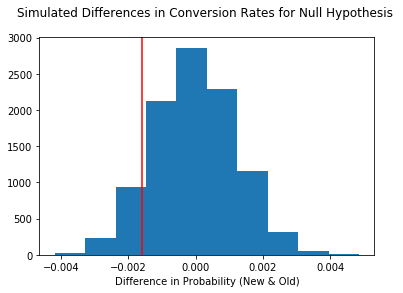

In [93]:
plt.hist(p_diffs);
plt.title("Simulated Differences in Conversion Rates for Null Hypothesis \n");
plt.xlabel("Difference in Probability (New & Old)");
plt.axvline(obs_diff, color='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [94]:
(p_diffs > obs_diff).mean()

0.89810000000000001

>This indicates a p-value of 0.90

>The above value calculated is called the p-value. Computing the p-value helps us determine the probability of of observing a statistic if the null hypothesis is true. Our Type I Error for this case is 0.05 and the p-value is large enough to say that we fail to reject the null. 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Steps below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [95]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" & converted == 1')['converted'].count()
convert_new = df2.query('group == "treatment" & converted == 1')['converted'].count()
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now using `stats.proportions_ztest` to compute your test statistic and p-value.

In [96]:
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

>The z-score (-1.31) and p-value (0.90) computed above align with the ones that are found through the 10,000 iterations (bootstrapping) hypothesis testing. We have now found that in both methods, we fail to reject the null hypothesis. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

> We can use the logistic regression model here as we have only two outcomes of conversion or no conversion. 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, I first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Adding an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [97]:
#add an intercept to df2
df2['intercept']=1

In [99]:
#create dummy variables 
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


> We can see that the **ab_page** is 1 when it receives the treatment and 0 if control. 

c. Using **statsmodels** to instantiate the regression model on the two columns created in part b., then fitting the model using the two columns created in part **b.** to predict whether or not an individual converts. 

In [108]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Providing the summary of the model below

In [109]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 17 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        09:42:09   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br>

> The p-value associated with the ab_page is 0.190. The null and alternative that is considered in Part II and Part III differ and hence is different. 
  
>Part II Null Hypothesis : $H_0: p_{new} - p_{old} <=0$        
Part II Alternative Hypothesis: $H_1:p_{new} - p_{old} >0$<br>
   
>Part III Null Hypothesis : $H_0: p_{old} - p_{new} =0$        
Part III Alternative Hypothesis: $H_1:p_{old} - p_{new} \not=0$

f. Now, I am considering other things that might influence whether or not an individual converts. Are there any disadvantages to adding additional terms into my regression model?

>There might be other factors such as geographical location which influences the language of the page seen, time of day when the user is viewing the page. The only disadvantage is that adding additional terms might increase complexity of the regression model but it does help us interpet and understand the results of our tests in a better manner. 

g. Now along with testing if the conversion rate changes for different pages, also adding an effect based on which country a user lives in. 

In [110]:
#Reading the countries.csv file
df_countries = pd.read_csv('countries.csv')
df_countries.head()


,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [111]:
#checking to see how many countries are there in the country column
df_countries.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [112]:
#creating dummy variables
df_countries[['CA', 'UK', 'US']] = pd.get_dummies(df_countries['country'])
df_countries.head()

,user_id,country,CA,UK,US
0,834778,UK,0,1,0
1,928468,US,0,0,1
2,822059,UK,0,1,0
3,711597,UK,0,1,0
4,710616,UK,0,1,0


> We have three countries in this column, we will need to create dummy variables for these categorical variables but we will only need 2. 

In [117]:
#checking how many rows are there in the df2 dataset before the merge
df2.shape[0]

290584

In [114]:
#merging the datasets
df_new = df_countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,CA,UK,US,timestamp,group,landing_page,converted,intercept,ab_page,old_page
user_id,,,,,,,,,,,
834778,UK,0,1,0,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,0,0,1,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0
822059,UK,0,1,0,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0
711597,UK,0,1,0,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,0,1,0,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0


In [116]:
#check to see if all rows are captured after the merge
df_new.shape[0]

290584

In [121]:
#Fitting the Regression model
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'US', 'UK']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 17 Jul 2020   Pseudo R-squ.:               1.521e-05
Time:                        10:06:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US             0.0408      0.027      1.518      0.129      -0.012       0.093
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
==============================================================================
"""

> Using Canada (CA) as the baseline (it was dropped), we can see that the coef of correlation is small for US and UK, indicating a weak relationship between the variables. The likelihood of conversion is pretty similar regardless of the country from where the user is viewing the site. 

h. Though I have now looked at the individual factors of country and page on conversion, I would now like to look at an interaction between page and country to see if there significant effects on conversion.

In [122]:
#checking for interaction between page and country
df_new['US_pg'] = df_new['US'] * df_new['ab_page']
df_new['UK_pg'] = df_new['UK'] * df_new['ab_page']
df_new.head()

,country,CA,UK,US,timestamp,group,landing_page,converted,intercept,ab_page,old_page,CA_page,UK_page,US_pg,UK_pg
user_id,,,,,,,,,,,,,,,
834778,UK,0,1,0,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,0,0
928468,US,0,0,1,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1,0
822059,UK,0,1,0,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0,1
711597,UK,0,1,0,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,0,0
710616,UK,0,1,0,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0,1


In [124]:
#Fitting the new model
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'UK', 'US_pg', 'UK_pg']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 17 Jul 2020   Pseudo R-squ.:               3.482e-05
Time:                        10:08:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US_pg          0.0469      0.054      0.872      0.383      -0.059       0.152
UK_pg          0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

>There seems to be no siginificant effect on the conversion of the page by the interaction of countries as well. Therefore, we can once again fail to reject the null hypothesis. 

### Conclusions
The objective of this project was to assess whether the company should switch to the new page or continue with the old page.We used various methods to assess this:


**Using Probability:**
We found that the probability of an individual viewing the old page vs. the new page was the same i.e. 0.5


**A/B test:**
In A/B test we set up our null and alternative hypothesis to test whether the new page has better conversions. By running the simulation using bootstrapped methods, we found the p_value to be 0.90. Given this p-value, we failed to reject the null.

**Regression Approach:**
We used logistic regression test as we were concerned with only two outcomes. Here, we saw a different p-value, however the value itself again indicated that we failed to reject the null. We also saw whether adding additional factors would influence the result and checked this as well, however we saw that this has no considerable impact. 

**Aspects we did not consider, but could have influenced the results:**
- Change aversion effects, which might influence users toward the old page 
- Novelty effects, which might influence users toward the new page/ different design

### Resources
- Udacity course videos + notes (Data Analyst Nano Degree)
- Understanding statsmodel (https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/)
- Intro to Hypothesis Testing (https://dfrieds.com/math/z-tests.html)
- Logistic Regression (https://realpython.com/logistic-regression-python/)